# Now let's start extracting concepts from unstructured text!


In [1]:
# Install medcat
! pip install medcat==1.3.0
try:
    from medcat.cat import CAT
except:
    print("WARNING: Runtime will restart automatically and please run other cells thereafter.")
    exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 |████████████████████████████████| 133 kB 5.0 MB/s 
 |████████████████████████████████| 281 kB 33.2 MB/s 
 |████████████████████████████████| 115 kB 17.8 MB/s 
 |████████████████████████████████| 5.9 MB 6.9 MB/s 
 |████████████████████████████████| 4.2 MB 25.4 MB/s 
 |████████████████████████████████| 212 kB 42.0 MB/s 
 |████████████████████████████████| 24.1 MB 1.7 MB/s 
 |████████████████████████████████| 177 kB 38.8 MB/s 
 |████████████████████████████████| 346 kB 40.0 MB/s 
 |████████████████████████████████| 385 kB 39.7 MB/s 
 |████████████████████████████████| 121 kB 36.9 MB/s 
 |████████████████████████████████| 9.9 MB 10.5 MB/s 
 |████████████████████████████████| 86 kB 4.7 MB/s 
 |████████████████████████████████| 120 kB 40.8 MB/s 
 |████████████████████████████████| 1.6 MB 17.3 MB/s 
 |████████████████████████████████| 245 kB 34.8 MB/s 
 |████████████████████████████████| 1.6 M

**Restart the runtime if on colab, sometimes necessary after installing models**

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
from medcat.cat import CAT

/usr/local/lib/python3.7/dist-packages/medcat/cat.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
 from tqdm.autonotebook import tqdm, trange


In [2]:
DATA_DIR = "./data_p3.2/"
! DATA_DIR="./data_p3.2/"
model_pack_path = DATA_DIR + "medmen_wstatus_2021_oct.zip"

In [3]:
# Download the models and required data
!wget -N https://medcat.rosalind.kcl.ac.uk/media/medmen_wstatus_2021_oct.zip -P $DATA_DIR
!wget -N https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/pt_notes.csv -P $DATA_DIR

--2022-08-25 11:58:20-- https://medcat.rosalind.kcl.ac.uk/media/medmen_wstatus_2021_oct.zip
Resolving medcat.rosalind.kcl.ac.uk (medcat.rosalind.kcl.ac.uk)... 193.61.202.225
Connecting to medcat.rosalind.kcl.ac.uk (medcat.rosalind.kcl.ac.uk)|193.61.202.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561947681 (536M) [application/zip]
Saving to: ‘./data/medmen_wstatus_2021_oct.zip.1’

medmen_wstatus_2021 100%[===================>] 535.92M 27.2MB/s in 20s 

2022-08-25 11:58:41 (26.6 MB/s) - ‘./data/medmen_wstatus_2021_oct.zip.1’ saved [561947681/561947681]

--2022-08-25 11:58:41-- https://raw.githubusercontent.com/CogStack/MedCATtutorials/main/notebooks/introductory/data/pt_notes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

## Loading the MedCAT modelpack

In [4]:
# Load model pack and Create CAT - the main class from medcat used for concept annotation
cat = CAT.load_model_pack(model_pack_path)


INFO:medcat:{
 "Model ID": null,
 "Last Modified On": null,
 "History (from least to most recent)": [],
 "Description": "No description",
 "Source Ontology": null,
 "Location": null,
 "MetaCAT models": {},
 "Basic CDB Stats": {},
 "Performance": {
 "ner": {},
 "meta": {}
 },
 "Important Parameters (Partial view, all available in cat.config)": {
 "config.ner['min_name_len']": {
 "value": 3,
 "description": "Minimum detection length (found terms/mentions shorter than this will not be detected)."
 },
 "config.ner['upper_case_limit_len']": {
 "value": 3,
 "description": "All detected terms shorter than this value have to be uppercase, otherwise they will be ignored."
 },
 "config.linking['similarity_threshold']": {
 "value": 0.2,
 "description": "If the confidence of the model is lower than this a detection will be ignore."
 },
 "config.general['spell_check']": {
 "value": true,
 "description": "Is spell checking enabled."
 },
 "config.general['spell_check_len_limit']": {
 "value": 7,
 "de

## Testing Named Entity Recognition + Linking (NER+L)

In [5]:
text = "He was diagnosed with kidney failure"
doc = cat(text)
print(doc.ents)

(diagnosed, kidney failure)


In [6]:
# To see all entities and corresponding meta-data
cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {0: {'pretty_name': 'Diagnosis',
 'cui': 'C0011900',
 'type_ids': ['T060'],
 'types': ['Diagnostic Procedure'],
 'source_value': 'diagnosed',
 'detected_name': 'diagnosed',
 'acc': 0.3913008909798732,
 'context_similarity': 0.3913008909798732,
 'start': 7,
 'end': 16,
 'icd10': [],
 'ontologies': [],
 'snomed': [],
 'id': 0,
 'meta_anns': {'Status': {'value': 'Affirmed',
 'confidence': 0.9999933838844299,
 'name': 'Status'}}},
 2: {'pretty_name': 'Kidney Failure',
 'cui': 'C0035078',
 'type_ids': ['T047'],
 'types': ['Disease or Syndrome'],
 'source_value': 'kidney failure',
 'detected_name': 'kidney~failure',
 'acc': 1.0,
 'context_similarity': 1.0,
 'start': 22,
 'end': 36,
 'icd10': [],
 'ontologies': [],
 'snomed': [],
 'id': 2,
 'meta_anns': {'Status': {'value': 'Affirmed',
 'confidence': 0.9999961853027344,
 'name': 'Status'}}}},
 'tokens': []}

In [7]:
# If we want to see the CUI (ID) for each entity
for ent in doc.ents:
    print(ent, " - ", ent._.cui)

diagnosed - C0011900
kidney failure - C0035078


In [8]:
# To show type_ids and types for each entity
for ent in doc.ents:
    print(ent, " - ", cat.cdb.cui2type_ids.get(ent._.cui))

diagnosed - {'T060'}
kidney failure - {'T047'}


In [9]:
# We can also show the entities in a nicer way using displacy form spaCy
from spacy import displacy
displacy.render(doc, style='ent', jupyter=True)

## Load the data

In [10]:
# Load the dataset - the one we saved in the last step of Part 2.
#If using MIMIC-III this is a very big dataset, be careful with memory requirements.
data = pd.read_csv(DATA_DIR + "pt_notes.csv")

In [11]:
# In this step we are only interested in the *text* column
data.head()

,Unnamed: 0_x,subject_id,chartdate,category,text,create_year,Unnamed: 0_y,gender,dob,dob_year,age_year
0,6,1,2079-01-01,General Medicine,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
1,7,1,2079-01-01,Rheumatology,"HISTORY OF PRESENT ILLNESS: , A 71-year-old fe...",2079,1,F,2018-01-01,2018,61
2,8,1,2079-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
3,9,2,2037-01-01,Consult - History and Phy.,"CHIEF COMPLAINT:,1. Infection.,2. Pelvic pai...",2037,2,F,2018-01-01,2018,19
4,10,2,2037-01-01,Dermatology,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",2037,2,F,2018-01-01,2018,19


## Run unsupervised training

In [12]:
# The first step that we want to do when using MedCAT is unsupervised training.
# You can find a full explanation of this process in the paper:
# https://doi.org/10.1016/j.artmed.2021.102083

# Print statistics on the CDB before training (note that if you are using the 
#medmen cdb it will already have some training)

cat.cdb.print_stats()

# Run the annotation procedure over all the documents we have,
#given that we have a large number of documents this can take quite some time.
print()
print(f"There are {len(data['text'])} documents to train...")

cat.train(data.text.values, progress_print=100)

# Now print statistics on the CDB after training
cat.cdb.print_stats()

INFO:medcat.cdb:{
 "Number of concepts": 34724,
 "Number of names": 92740,
 "Number of concepts that received training": 34724,
 "Number of seen training examples in total": 4079076,
 "Average training examples per concept": 117.47137426563759
}



There are 1088 documents to train...


INFO:medcat:DONE: 100
INFO:medcat:DONE: 200
INFO:medcat:DONE: 300
INFO:medcat:DONE: 400
INFO:medcat:DONE: 500
INFO:medcat:DONE: 600
INFO:medcat:DONE: 700
INFO:medcat:DONE: 800
INFO:medcat:DONE: 900
INFO:medcat:DONE: 1000
INFO:medcat.cdb:{
 "Number of concepts": 34724,
 "Number of names": 92740,
 "Number of concepts that received training": 34724,
 "Number of seen training examples in total": 4098994,
 "Average training examples per concept": 118.04498329685521
}


## Save the new MedCAT modelpack

In [13]:
# unsupervised trained model
model_pack_name = cat.create_model_pack(DATA_DIR + "unsupervised_trained_model_pack")

INFO:medcat:{
 "Model ID": "2983a0bc35c323cf",
 "Last Modified On": "25 August 2022",
 "History (from least to most recent)": [],
 "Description": "No description",
 "Source Ontology": null,
 "Location": null,
 "MetaCAT models": [
 {
 "Category Name": "Status",
 "Description": "No description",
 "Classes": {
 "Affirmed": 0,
 "Other": 1
 },
 "Model": "lstm"
 }
 ],
 "Basic CDB Stats": {
 "Number of concepts": 34724,
 "Number of names": 92740,
 "Number of concepts that received training": 34724,
 "Number of seen training examples in total": 4098994,
 "Average training examples per concept": 118.04498329685521
 },
 "Performance": {
 "ner": {},
 "meta": {}
 },
 "Important Parameters (Partial view, all available in cat.config)": {
 "config.ner['min_name_len']": {
 "value": 3,
 "description": "Minimum detection length (found terms/mentions shorter than this will not be detected)."
 },
 "config.ner['upper_case_limit_len']": {
 "value": 3,
 "description": "All detected terms shorter than this va

# Annotate Documents

For this task we will annotate documents using the UMLS unsupervised model created above.

The Type_ids in this CDB correspond to the Semantic Type(TUI) found within UMLS

In [14]:
# Load the newly created MedCAT modelpack
model_pack_path_2 = DATA_DIR + "unsupervised_trained_model_pack/" + model_pack_name + ".zip"
cat = CAT.load_model_pack(model_pack_path_2)

INFO:medcat:Found an existing unziped model pack at: ./data/unsupervised_trained_model_pack/medcat_model_pack_2983a0bc35c323cf, the provided zip will not be touched.
INFO:medcat:{
 "Model ID": "2983a0bc35c323cf",
 "Last Modified On": "25 August 2022",
 "History (from least to most recent)": [],
 "Description": "No description",
 "Source Ontology": null,
 "Location": null,
 "MetaCAT models": [
 {
 "Category Name": "Status",
 "Description": "No description",
 "Classes": {
 "Affirmed": 0,
 "Other": 1
 },
 "Model": "lstm"
 }
 ],
 "Basic CDB Stats": {
 "Number of concepts": 34724,
 "Number of names": 92740,
 "Number of concepts that received training": 34724,
 "Number of seen training examples in total": 4098994,
 "Average training examples per concept": 118.04498329685521
 },
 "Performance": {
 "ner": {},
 "meta": {}
 },
 "Important Parameters (Partial view, all available in cat.config)": {
 "config.ner['min_name_len']": {
 "value": 3,
 "description": "Minimum detection length (found terms

We are not interested in all medical concepts that exist in UMLS, that is why we will filter by Semantic Type (TUI) to only:
1. T047 - Disease or Syndrome
2. T048 - Mental or Behavioral Dysfunction

It is possible to filter after the detection process, but always better to define the filter as part of MedCAT

A full list of semantic types in UMLS is available [here](https://metamap.nlm.nih.gov/Docs/SemanticTypes_2018AB.txt).

In [15]:
# IMPORTANT: Set TUI/Type Ids filters
# |T047|Disease or Syndrome
# |T048|Mental or Behavioral Dysfunction
type_ids_filter = ['T047', 'T048']
cui_filters = set()
for type_ids in type_ids_filter:
    cui_filters.update(cat.cdb.addl_info['type_id2cuis'][type_ids])
cat.cdb.config.linking['filters']['cuis'] = cui_filters
print(f"The size of the cdb is now: {len(cui_filters)}")


The size of the cdb is now: 1763


For each row in our dataframe `data` we want to get all diseases that appear in the `text` column. In UMLS a disease is defined by a CUI, so we want to have the following output after the annotation is done:
```
cui_location = {<CUI>: [<row_id>, <row_id>, ...], ...}
```

## Get entities from unstructured text
We can annotate a portion of text.

In [16]:
annotated_text = cat.get_entities("This patient suffers from diabetes.")

In [17]:
annotated_text

{'entities': {2: {'pretty_name': 'Diabetes',
 'cui': 'C0011847',
 'type_ids': ['T047'],
 'types': ['Disease or Syndrome'],
 'source_value': 'diabetes',
 'detected_name': 'diabete',
 'acc': 0.7613368393011193,
 'context_similarity': 0.7613368393011193,
 'start': 26,
 'end': 34,
 'icd10': [],
 'ontologies': [],
 'snomed': [],
 'id': 2,
 'meta_anns': {'Status': {'value': 'Affirmed',
 'confidence': 0.9999899864196777,
 'name': 'Status'}}}},
 'tokens': []}

There is one concept Entity extracted from the sample text above. Feel free to try it out for yourself by altering the text.

Don't forget that we applied the type_ids filter for [T047 & T048] so only concepts which fall within these categories will be shown.

## Use Multiprocessing

Although we can annotate documents one by one, using the `annotated_document = cat(text)` option, but it will work much faster if we do it using the `multi_processing` method from medcat.

When using multi_processing medcat requires the following format for input documents:
```
in_data = [(doc_id, doc_text), (doc_id, doc_text), ...]
```
The output is (return from medcat):
```
out_data = [(doc_id, {'entities': [...], 'text': <...>), (doc_id, {'entities': [...], 'text': <...>}), ...]
```

NOTE: If using the full UMLS CDB and a lot of processors (e.g. 32) it is very memory demanding (~ 32GB). The annotation process on 32 processors and 1M large text documents takes ~1h. 

In [18]:
# Let's test the multi processing function first
in_data = [(1, "He was a diabetic patient")]
results = cat.multiprocessing(in_data, nproc=2)
results

INFO:medcat:Annotated until now: 0 docs; Current BS: 1 docs; Elapsed time: 0.00 minutes


{1: {'entities': {0: {'pretty_name': 'Diabetes',
 'cui': 'C0011847',
 'type_ids': ['T047'],
 'types': ['Disease or Syndrome'],
 'source_value': 'diabetic',
 'detected_name': 'diabetic',
 'acc': 0.824328935192448,
 'context_similarity': 0.824328935192448,
 'start': 9,
 'end': 17,
 'id': 0,
 'meta_anns': {'Status': {'value': 'Affirmed',
 'confidence': 0.999995231628418,
 'name': 'Status'}}}},
 'tokens': []}}

The returned list of `entities` contains the following:

`acc` - Confidence score for this detection

`cui` - ID of the detected entity in the CDB (in our case UMLS)

`pretty_name` - The pretty name for this entity linked with the CUI

`detected_name` - What exact source value was detected

`type_ids` - The category code

`types` - Description label of the type_ids

`start` - The start character for the entity in the original string

`end` - End character for the entity in the original string

`id` - Internal ID, each entity inside a document has an unique ID


__Optional parameters which can also be set:__

The following can also be set to be returned during the creation of the MedCAT CDB within the model pack

`icd10` - If we are using a medical CDB, we'll also get ICD10 codes

`umls` - If the CDB was something other than UMLS, we would get the potential link to UMLS.

`snomed` - If we are using a medical CDB this would link to the equivalent SNOMED concept

In [19]:
data.shape

(1088, 11)

In [20]:
# Think about removing text you don't want to annotate. E.g <10 characters
data = data[data.text.apply(lambda x: len(str(x))>10)]

In [21]:
# format the df to match: in_data = [(doc_id, doc_text), (doc_id, doc_text), ...]
in_data = []
for id, row in data[['text']].iterrows():
    text = row['text']
    in_data.append((id, text))

In [22]:
# Set a batch size to control for the variablity between document sizes
batch_size_chars = 500000 # Batch size (BS) in number of characters

# Run model
results = cat.multiprocessing(in_data, # Formatted data
                              batch_size_chars = batch_size_chars,
                              nproc=8) # Number of processors

INFO:medcat:Annotated until now: 0 docs; Current BS: 157 docs; Elapsed time: 0.00 minutes
INFO:medcat:Annotated until now: 157 docs; Current BS: 165 docs; Elapsed time: 1.42 minutes
INFO:medcat:Annotated until now: 322 docs; Current BS: 151 docs; Elapsed time: 2.89 minutes
INFO:medcat:Annotated until now: 473 docs; Current BS: 160 docs; Elapsed time: 4.30 minutes
INFO:medcat:Annotated until now: 633 docs; Current BS: 152 docs; Elapsed time: 5.68 minutes
INFO:medcat:Annotated until now: 785 docs; Current BS: 130 docs; Elapsed time: 7.06 minutes
INFO:medcat:Annotated until now: 915 docs; Current BS: 157 docs; Elapsed time: 8.42 minutes
INFO:medcat:Annotated until now: 1072 docs; Current BS: 16 docs; Elapsed time: 9.91 minutes


To batch on the number of documents, you can use `multiprocessing_pipe` alternatively, which also supports Windows platforms:

In [23]:
# Set the batch size to the number of documents
batch_size = 100 # Batch size (BS) in number of documents

# Run model
if __name__ == '__main__':
    import torch
    torch.multiprocessing.set_start_method('spawn', force=True)
    results = cat.multiprocessing_pipe(in_data, # Formatted data
                                       batch_size = batch_size,
                                       nproc=2) # Increase it when having more cores available

 0%| | 0/1088 [00:00<?, ?it/s]

For a quick sanity check. Let's inspect a document and the annotations that our unsupervised model has produced.

In [24]:
# Check one of the returned results, just in case
data.iloc[0]['text']

"HISTORY OF PRESENT ILLNESS:, The patient is a 71-year-old Caucasian female with a history of diabetes, osteoarthritis, atrial fibrillation, hypertension, asthma, obstructive sleep apnea on CPAP, diabetic foot ulcer, anemia and left lower extremity cellulitis. She was brought in by the EMS service to Erlanger emergency department with pulseless electrical activity. Her husband states that he was at home with his wife, when she presented to him complaining of fever and chills. She became acutely unresponsive. She was noted to have worsening of her breathing. She took several of her MDIs and then was placed on her CPAP. He went to notify EMS and when he returned, she was found to not be breathing. He stated that she was noted to have no breathing in excess of 10 minutes. He states that the EMS system arrived at the home and she was found not breathing. The patient was intubated at the scene and upon arrival to Erlanger Medical Center, she was found to have pupils fixed and dilated. She w

In [25]:
# See all annotations based on the filter set above. 
# Notice that entities not present in the filter are filtered out.
cui_list = []
for annotation in list(results[0]['entities'].values()):
    print(annotation['cui'], annotation['pretty_name'])
    print()

C0011847 Diabetes

C0029408 Degenerative polyarthritis

C0004238 Atrial Fibrillation

C0020538 Hypertensive disease

C0004096 Asthma

C0520679 Sleep Apnea, Obstructive

C1456868 Diabetic foot ulcer

C0002871 Anemia

C0020538 Hypertensive disease

C0011847 Diabetes

C0029408 Degenerative polyarthritis

C0020538 Hypertensive disease

C0004096 Asthma

C0004238 Atrial Fibrillation

C1456868 Diabetic foot ulcer

C0002871 Anemia

C0010054 Coronary Arteriosclerosis

C0018790 Cardiac Arrest

C1145670 Respiratory Failure

C0034065 Pulmonary Embolism

C0027051 Myocardial Infarction

C0035222 Respiratory Distress Syndrome, Adult

C0243026 Sepsis



For an unsupervised model, not too bad right?

Later we'll explore how we can boost the models performance even further through providing annotation labels created via the annotation tool: MedCATtrainer!

In [26]:
# If we want to convert a CUI back to its name
cat.cdb.cui2preferred_name['C0041834']

'Erythema'

In [27]:
# To see all names in the concept db
cat.cdb.cui2names['C0041834']

{'erythema', 'erythematous', 'redness'}

In [28]:
# If we want to see the type_ids
cat.cdb.cui2type_ids['C0041834']

{'T047'}

Now that you have created a structured annotation dataset you can now use this for any number of downstream applications! 

But for now let's continue on with the task and explore the annotations by finding the UMLS cui and type_ids (TUI as it is from UMLS) and their corresponding list of documents in which they are mentioned.

In [29]:
# This will be a map from CUI to a list of documents where it appears: {"cui": [<doc_id>, <doc_id>, ...], ..}
cui_location = {}
# Let's also save the type_ids location
type_ids_location = {}

In [30]:
# For the cui and thier corresponding documents
for doc in list(results.keys()):
    for annotation in list(results[doc]['entities'].values()):
        if annotation['cui'] in cui_location:
            cui_location[annotation['cui']].append(doc)
        else:
            cui_location[annotation['cui']] = [doc]

In [31]:
# For the type_ids and their corresponding documents
# Remember that a cui may map to more than one type_ids (one to many mapping)
for cui in cui_location.keys():
    type_ids_location[list(cat.cdb.cui2type_ids[cui])[0]] = cui_location[cui]

In [32]:
# Save the data so that we don't have to do the annotation again
pickle.dump(cui_location, open(DATA_DIR + "cui_location.dat", 'wb'))
pickle.dump(type_ids_location, open(DATA_DIR + "type_ids_location.dat", 'wb'))

In [33]:
# Load
cui_location = pickle.load(open(DATA_DIR + "cui_location.dat", 'rb'))
type_ids_location = pickle.load(open(DATA_DIR + "type_ids_location.dat", 'rb'))

## Visualise the annotation frequency
Let's explore the annotation counts visually to double check that everything makes sense.

In [34]:
# We are going to count the number of subjects (patients) for each CUI
cui_subjects = {}
cui_subjects_unique = {}
for cui in cui_location:
    for location in cui_location[cui]:
        subject_id = data.iat[location, list(data.columns).index('subject_id')]
        if cui in cui_subjects:
            cui_subjects[cui].append(subject_id)
            cui_subjects_unique[cui].add(subject_id)
        else:
            cui_subjects[cui] = [subject_id]
            cui_subjects_unique[cui] = {subject_id}

In [35]:
cui_nsubjects = [('cui', 'nsubjects')]
for cui in cui_subjects_unique.keys():
    cui_nsubjects.append((cui, len(cui_subjects_unique[cui])))
df_cui_nsubjects = pd.DataFrame(cui_nsubjects[1:], columns=cui_nsubjects[0])

Add a couple of columns that can be useful

In [36]:
df_cui_nsubjects = df_cui_nsubjects.sort_values('nsubjects', ascending=False)
# Add type_ids for each CUI
df_cui_nsubjects['type_ids'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    type_ids = cat.cdb.cui2type_ids.get(cui, 'unk')
    df_cui_nsubjects.iat[i, cols.index('type_ids')] = type_ids
    
# Add name for each CUI
df_cui_nsubjects['name'] = ['unk'] * len(df_cui_nsubjects)
cols = list(df_cui_nsubjects.columns)
for i in range(len(df_cui_nsubjects)):
    cui = df_cui_nsubjects.iat[i, cols.index('cui')]
    name = cat.cdb.cui2preferred_name.get(cui, 'unk')
    df_cui_nsubjects.iat[i, cols.index('name')] = name


# Add the percentage column
total_subjects = len(data['subject_id'].unique())
df_cui_nsubjects['perc_subjects'] = (df_cui_nsubjects['nsubjects'] / total_subjects) * 100

df_cui_nsubjects.reset_index(drop=True, inplace=True)

In [37]:
# Inspect newly created df
df_cui_nsubjects.head()

,cui,nsubjects,type_ids,name,perc_subjects
0,C0020538,123,{T047},Hypertensive disease,67.582418
1,C0028754,83,{T047},Obesity,45.604396
2,C0038454,64,{T047},Cerebrovascular accident,35.164835
3,C0011847,61,{T047},Diabetes,33.516484
4,C0085762,54,{T048},Alcohol abuse,29.670330


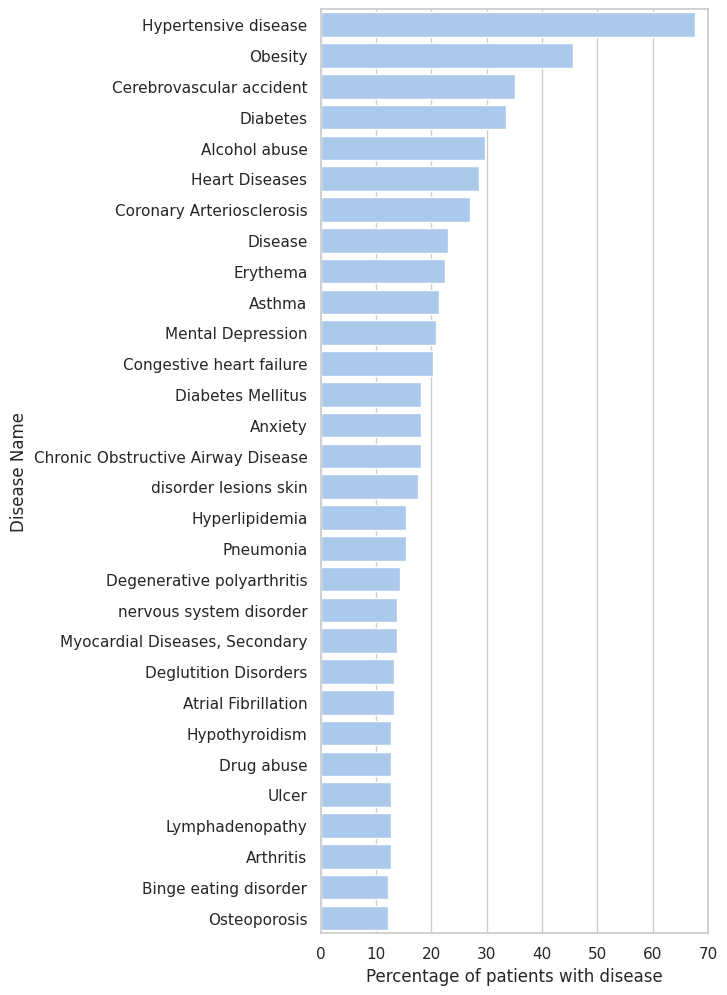

In [38]:
# Plot the top 30 diseases
sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(5,12)}, 
    style="whitegrid",
    palette='pastel'
)
f, ax = plt.subplots()
_data = df_cui_nsubjects.iloc[0:30]
sns.barplot(x="perc_subjects", y="name", data=_data, label="Disorder Name", color="b")
_ = ax.set(xlim=(0, 70), ylabel="Disease Name", xlabel="Percentage of patients with disease")
plt.show()

# Preparing data for supervised training (MedCATtrainer)

As we want to do some fine-tuning on the models and also some meta-annotations (e.g. Status and Temporality), we'll take the top 100 CUIs from each TUI and for each take 2 examples. We'll do this because randomly choosing documents will give us only (most likely) the concepts on the very top by frequency (especially when there is a large drop between the top concepts).

The required output format for supervised training via MedCATtrainer is CSV with `columns=(name, text)`

In [39]:
df_cui_nsubjects.head()

,cui,nsubjects,type_ids,name,perc_subjects
0,C0020538,123,{T047},Hypertensive disease,67.582418
1,C0028754,83,{T047},Obesity,45.604396
2,C0038454,64,{T047},Cerebrovascular accident,35.164835
3,C0011847,61,{T047},Diabetes,33.516484
4,C0085762,54,{T048},Alcohol abuse,29.670330


In [40]:
# For each of the top 30 diseases/mental_disorders take 2 examples of documents/text
#where they appear
nexamples = 2
size = 40
loc_047_top = []
loc_048_top = []

for cui in df_cui_nsubjects[df_cui_nsubjects['type_ids'].apply(lambda x: 'T047' in x)]['cui'].values[0:size]:
    loc_047_top.extend(np.array(cui_location[cui])[np.random.randint(0, len(cui_location[cui]), nexamples)])
    
for cui in df_cui_nsubjects[df_cui_nsubjects['type_ids'].apply(lambda x: 'T048' in x)]['cui'].values[0:size]:
    loc_048_top.extend(np.array(cui_location[cui])[np.random.randint(0, len(cui_location[cui]), nexamples)])

data_047_top = data.iloc[loc_047_top]
data_048_top = data.iloc[loc_048_top]

In [41]:
# Combine everything
train_data = pd.concat([data_047_top, data_048_top])

In [42]:
train_data.head()

,Unnamed: 0_x,subject_id,chartdate,category,text,create_year,Unnamed: 0_y,gender,dob,dob_year,age_year
282,549,76,2055-01-01,Consult - History and Phy.,"REASON FOR CONSULTATION: ,Followup of seizure...",2055,76,F,2018-01-01,2018,37
123,254,32,2069-01-01,Cardiovascular / Pulmonary,"CHIEF COMPLAINT:, Rule out obstructive sleep ...",2069,32,M,2018-01-01,2018,51
170,320,43,2063-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, This is a 55-yea...",2063,43,F,2018-01-01,2018,45
24,34,6,2088-01-01,Gastroenterology,"CHIEF COMPLAINT:, GI bleed.,HISTORY OF PRESEN...",2088,6,F,2018-01-01,2018,70
809,1563,219,2077-01-01,General Medicine,"CHIEF COMPLAINT:, Altered mental status.,HISTO...",2077,219,M,2018-01-01,2018,59


In [43]:
train_data = train_data.rename(columns={'Unnamed: 0_x': "name"})
train_data = train_data[['name', 'text']]
train_data.reset_index(drop=True, inplace=True)
train_data.head()

,name,text
0,549,"REASON FOR CONSULTATION: ,Followup of seizure..."
1,254,"CHIEF COMPLAINT:, Rule out obstructive sleep ..."
2,320,"HISTORY OF PRESENT ILLNESS:, This is a 55-yea..."
3,34,"CHIEF COMPLAINT:, GI bleed.,HISTORY OF PRESEN..."
4,1563,"CHIEF COMPLAINT:, Altered mental status.,HISTO..."


In [44]:
# Remove duplicates if we have them. 
train_data = train_data.drop_duplicates(['text'])

# Save the data so that it can be imported into MedCATtrainer
train_data.to_csv(DATA_DIR + "train_data.csv", index=False)

End of Tutorial